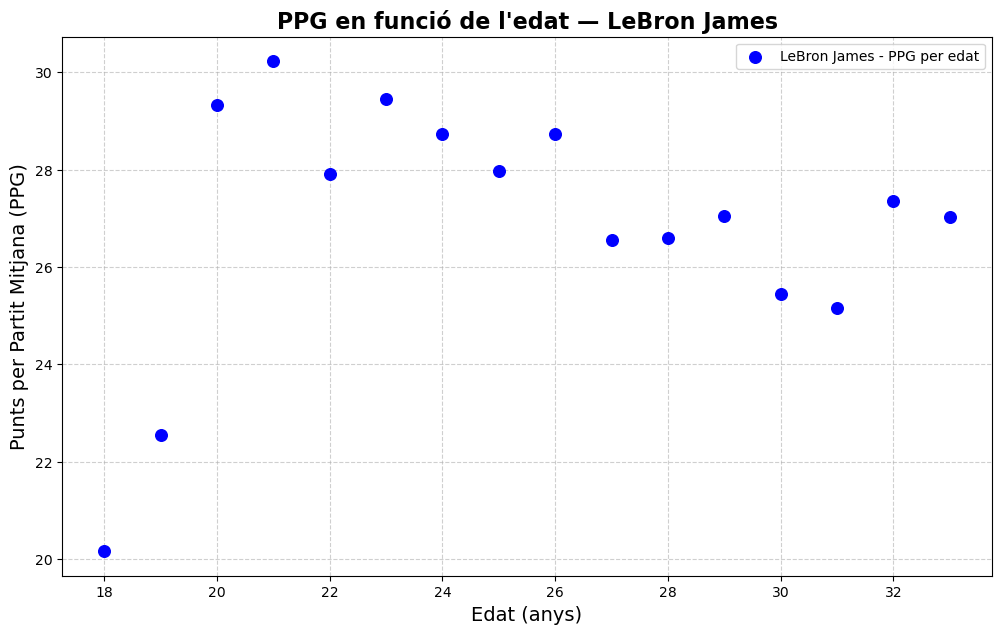

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Carregar datasets 
try:
    lebron = pd.read_csv("lebron_career.csv", sep=";")
except FileNotFoundError:
    print("Error: No es poden carregar els arxius CSV.")
    raise

# Funció per extreure l'edat
def extract_age(age_str):
    if pd.isna(age_str) or not isinstance(age_str, str) or '-' not in age_str:
        return None
    try:
        return int(age_str.split("-")[0])
    except ValueError:
        return None

# Preprocessat per LeBron
for df in [lebron]:
    df["age_years"] = df["age"].apply(extract_age)
    df["pts"] = pd.to_numeric(df["pts"], errors="coerce")
    df.dropna(subset=["age_years", "pts"], inplace=True)

# PPG mitjà per edat
lebron_avg = lebron.groupby("age_years")["pts"].mean().reset_index()

# Gràfic
plt.figure(figsize=(12, 7))

# Punts Lebron
plt.scatter(lebron_avg["age_years"], lebron_avg["pts"],
            color='blue', label='LeBron James - PPG per edat', s=70, zorder=5)

# Títols i estil
plt.title('PPG en funció de l\'edat — LeBron James', fontsize=16, fontweight='bold')
plt.xlabel('Edat (anys)', fontsize=14)
plt.ylabel('Punts per Partit Mitjana (PPG)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


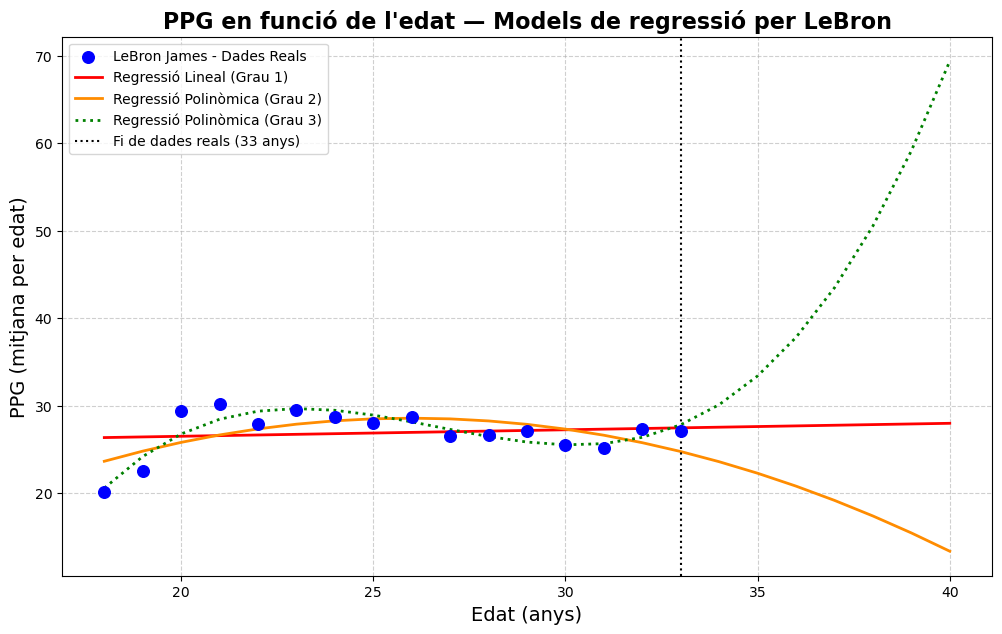

In [38]:

plt.figure(figsize=(12, 7))

# Punts Lebron
plt.scatter(lebron_avg["age_years"], lebron_avg["pts"],
            color='blue', label='LeBron James - Dades Reals', s=70, zorder=5)

# Corbes de regressió

# Regressió Grau 1 (lineal)
plt.plot(X_predict, model_linear.predict(X_predict),
         linestyle='-', color='red', linewidth=2,
         label='Regressió Lineal (Grau 1)')

# Regressió Grau 2 (polinòmica)
plt.plot(X_predict, model_poly_2.predict(X_predict),
         linestyle='-', color='darkorange', linewidth=2,
         label='Regressió Polinòmica (Grau 2)')

# Regressió Grau 3 (cúbica)
plt.plot(X_predict, model_poly_3.predict(X_predict),
         linestyle=':', color='green', linewidth=2,
         label='Regressió Polinòmica (Grau 3)')

# Línia de tall entre dades reals i extrapolació
plt.axvline(x=X_train.max(), color='black', linestyle=':', linewidth=1.5,
            label=f'Fi de dades reals ({int(X_train.max())} anys)')

# Gràfic
plt.title('PPG en funció de l\'edat — Models de regressió per LeBron', fontsize=16, fontweight='bold')
plt.xlabel('Edat (anys)', fontsize=14)
plt.ylabel('PPG (mitjana per edat)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


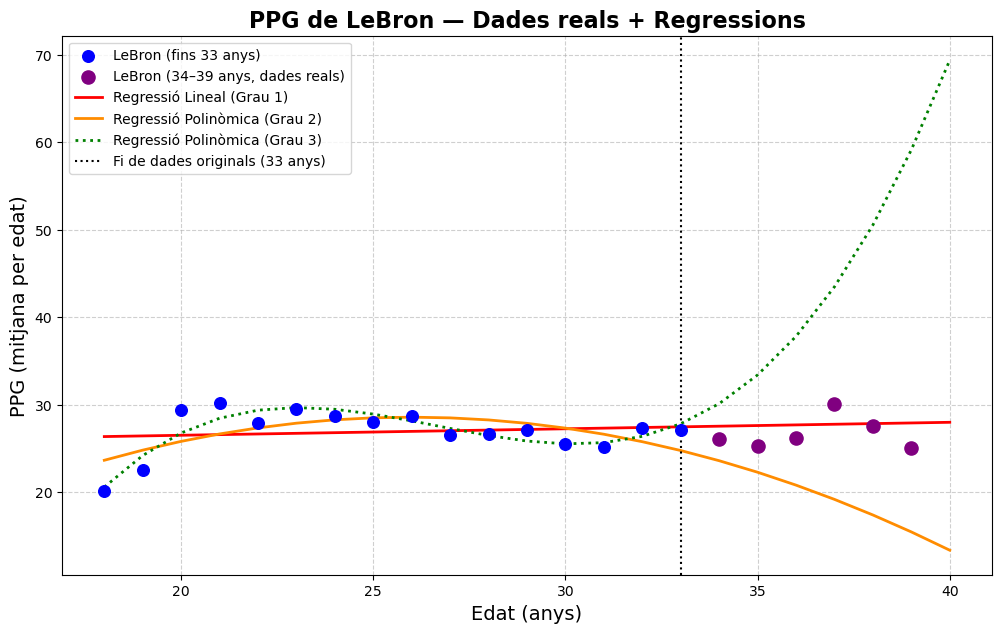

In [39]:

# Carregar dades de LeBron després dels 33 anys
lebron_post = pd.read_csv("lebron_career_post33.csv", sep=';')

# Eliminem columnes buides si n'hi ha (per exemple la última després del ;)
lebron_post = lebron_post.dropna(axis=1, how='all')

# Convertir a numèric
lebron_post["age"] = pd.to_numeric(lebron_post["age"], errors="coerce")
lebron_post["ppg"] = pd.to_numeric(lebron_post["ppg"], errors="coerce")
lebron_post.dropna(inplace=True)

# Filtrar edats originals fins 33
lebron_upto33 = lebron_avg[lebron_avg["age_years"] <= 33]

# Gràfic
plt.figure(figsize=(12, 7))

# Dades originals (fins 33)
plt.scatter(
    lebron_upto33["age_years"], lebron_upto33["pts"],
    color='blue', label='LeBron (fins 33 anys)', s=70, zorder=5)

# Noves dades 34–39
plt.scatter(
    lebron_post["age"], lebron_post["ppg"],
    color='purple', label='LeBron (34–39 anys, dades reals)', s=90, zorder=6)

# Regressions
plt.plot(X_predict, model_linear.predict(X_predict),
         linestyle='-', color='red', linewidth=2,
         label='Regressió Lineal (Grau 1)')

plt.plot(X_predict, model_poly_2.predict(X_predict),
         linestyle='-', color='darkorange', linewidth=2,
         label='Regressió Polinòmica (Grau 2)')

plt.plot(X_predict, model_poly_3.predict(X_predict),
         linestyle=':', color='green', linewidth=2,
         label='Regressió Polinòmica (Grau 3)')

plt.axvline(x=X_train.max(), color='black', linestyle=':', linewidth=1.5,
            label=f'Fi de dades originals ({int(X_train.max())} anys)')

plt.title("PPG de LeBron — Dades reals + Regressions", fontsize=16, fontweight="bold")
plt.xlabel("Edat (anys)", fontsize=14)
plt.ylabel("PPG (mitjana per edat)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


In [41]:

# PREPARAR DADES REALS 34–39
ages_real = lebron_post["age"].values.reshape(-1, 1)
ppg_real = lebron_post["ppg"].values

# PREDICCIONS DELS MODELS
pred_linear = model_linear.predict(ages_real)
pred_poly2  = model_poly_2.predict(ages_real)
pred_poly3  = model_poly_3.predict(ages_real)

# CALCULAR ERRORS
def compute_errors(preds, real):
    abs_error = np.abs(preds - real)
    rel_error = abs_error / real * 100
    accuracy = 100 - rel_error   # percentatge d'encert
    return abs_error, rel_error, accuracy

err_lin_abs, err_lin_rel, acc_lin = compute_errors(pred_linear, ppg_real)
err_p2_abs,  err_p2_rel,  acc_p2  = compute_errors(pred_poly2,  ppg_real)
err_p3_abs,  err_p3_rel,  acc_p3  = compute_errors(pred_poly3,  ppg_real)

# TAULA RESUM
results_df = pd.DataFrame({
    "Edat": lebron_post["age"],
    "PPG Real": ppg_real,
    "Pred Lineal": pred_linear,
    "Err Lin": err_lin_abs,
    "Acc Lin (%)": acc_lin,
    "Pred Grau 2": pred_poly2,
    "Err G2": err_p2_abs,
    "Acc G2 (%)": acc_p2,
    "Pred Grau 3": pred_poly3,
    "Err G3": err_p3_abs,
    "Acc G3 (%)": acc_p3
})

# Ample per defecte de cada columna, perquè es vegin els headers bé
col_width = 15

# Còpia formatada del DataFrame
formatted_df = results_df.copy()

for col in formatted_df.columns:
    formatted_df[col] = formatted_df[col].apply(
        lambda x: f"{x:.2f}".ljust(col_width) if isinstance(x, (int, float, np.float64)) 
        else str(x).ljust(col_width)
    )

# Imprimir headers amb més espai
header_row = "  ".join([h.ljust(col_width) for h in formatted_df.columns])
separator  = "-" * len(header_row)

print("\n===== COMPARACIÓ DE MODELS PER EDAT (34–39) =====\n")
print(header_row)
print(separator)

# Imprimir cada fila
for _, row in formatted_df.iterrows():
    print("  ".join([str(v).ljust(col_width) for v in row.values]))

print("\n")


# EVALUACIÓ GLOBAL
total_err_lin = err_lin_abs.sum()
total_err_p2  = err_p2_abs.sum()
total_err_p3  = err_p3_abs.sum()

print("\n===== ERROR TOTAL DE CADA MODEL =====")
print(f"Model Lineal (G1): {total_err_lin:.2f} punts d'error acumulat")
print(f"Model Polinòmic Grau 2: {total_err_p2:.2f} punts d'error acumulat")
print(f"Model Polinòmic Grau 3: {total_err_p3:.2f} punts d'error acumulat")

best_model = min(
    [("Lineal (G1)", total_err_lin),
     ("Polinòmic Grau 2", total_err_p2),
     ("Polinòmic Grau 3", total_err_p3)],
    key=lambda x: x[1]
)

print("\n===== MILLOR MODEL =====")
print(f"El millor model és: **{best_model[0]}**")



===== COMPARACIÓ DE MODELS PER EDAT (34–39) =====

Edat             PPG Real         Pred Lineal      Err Lin          Acc Lin (%)      Pred Grau 2      Err G2           Acc G2 (%)       Pred Grau 3      Err G3           Acc G3 (%)     
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
34.00            26.10            27.52            1.42             94.56            23.57            2.53             90.31            30.10            4.00             84.69          
35.00            25.30            27.59            2.29             90.93            22.25            3.05             87.96            33.38            8.08             68.05          
36.00            26.20            27.67            1.47             94.40            20.78            5.42             79.31            37.79            11.59            55.75          
37.00            3

--------- RESULTATS VALIDACIÓ CREUADA ---------

Regressió Logística:
  Accuracy CV: 0.8435

Random Forest:
  Accuracy CV: 0.8362



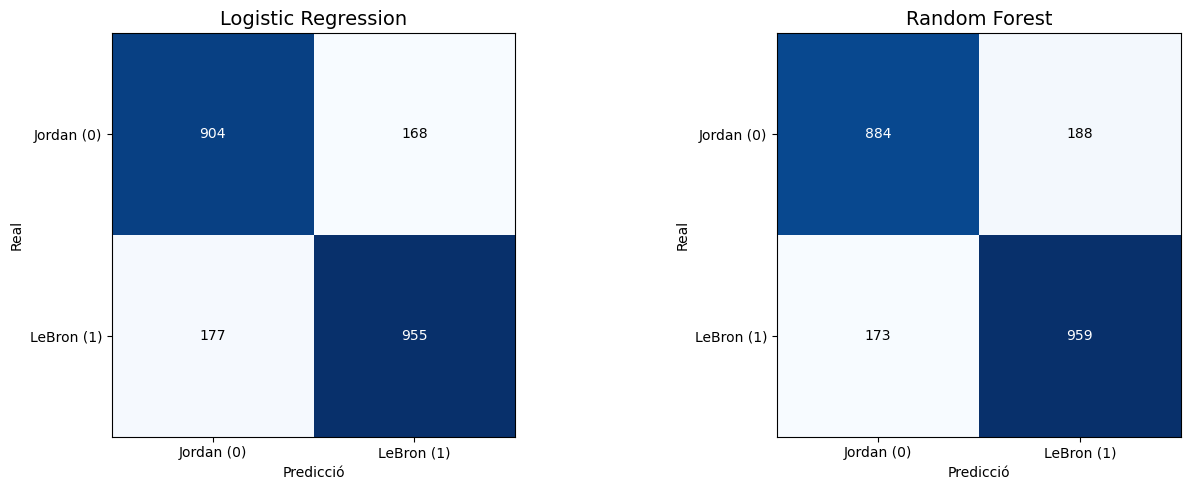

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


# ======================================================
# 1. CARREGA I TRACTAMENT INICIAL DE DADES
# ======================================================

df = pd.read_csv("careers.csv", sep=";")

# Convertir mp ("MM:SS") -> minuts decimals
def mp_to_minutes(mp_str):
    try:
        m, s = mp_str.split(":")
        return int(m) + int(s)/60
    except:
        return np.nan

df["mp"] = df["mp"].apply(mp_to_minutes)

# Convertir totes les columnes numèriques
for col in df.columns:
    if col != "player":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Omplir NaNs de percentatges (threep, ftp)
for col in ["threep", "ftp"]:
    df[col] = df[col].fillna(df[col].mean())


# ======================================================
# 2. FEATURE ENGINEERING
# ======================================================

eps = 1e-6

df["AST_per_PTS"] = df["ast"] / (df["pts"] + eps)
df["3PT_Attempt_Ratio"] = df["threeatt"] / (df["fga"] + eps)
df["TRB_per_FGA"] = df["trb"] / (df["fga"] + eps)

df.replace([np.inf, -np.inf], np.nan, inplace=True)


# ======================================================
# 3. TRACTAMENT FINAL DE NaNs
# ======================================================

for col in df.columns:
    if col != "player":
        df[col] = df[col].fillna(df[col].mean())


# ======================================================
# 4. DEFINIR X i Y
# ======================================================

X = df.drop(columns=["player"])
Y = df["player"]


# ======================================================
# 5. ESCALAT
# ======================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ======================================================
# 6. DEFINIR MODELS
# ======================================================

models = {
    "Regressió Logística": LogisticRegression(random_state=42, max_iter=2000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200)
}

# Trio ACCURACY com a mètrica, estan balancejats
scoring = ["accuracy"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}


# ======================================================
# 7. VALIDACIÓ CREUADA (ACCURACY)
# ======================================================

print("--------- RESULTATS VALIDACIÓ CREUADA ---------\n")

for name, model in models.items():
    cv_results = cross_validate(model, X_scaled, Y, cv=kf, scoring=scoring)

    results[name] = {
        "Accuracy Mitjana": np.mean(cv_results["test_accuracy"])
    }

    print(f"{name}:")
    print(f"  Accuracy CV: {results[name]['Accuracy Mitjana']:.4f}\n")


# ======================================================
# 8. MATRIUS DE CONFUSIÓ AMB CROSS_VAL_PREDICT
# ======================================================

def plot_confusion_matrix(cm, title, ax):
    labels = ["Jordan (0)", "LeBron (1)"]
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_title(title, fontsize=14)
    ax.set_xticks(range(2))
    ax.set_yticks(range(2))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    thresh = cm.max() / 2
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel("Real")
    ax.set_xlabel("Predicció")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression CM
preds_logreg = cross_val_predict(
    LogisticRegression(random_state=42, max_iter=2000),
    X_scaled, Y, cv=kf
)
cm_logreg = confusion_matrix(Y, preds_logreg)
plot_confusion_matrix(cm_logreg, "Logistic Regression", axes[0])

# Random Forest CM
preds_rf = cross_val_predict(
    RandomForestClassifier(random_state=42, n_estimators=200),
    X_scaled, Y, cv=kf
)
cm_rf = confusion_matrix(Y, preds_rf)
plot_confusion_matrix(cm_rf, "Random Forest", axes[1])

plt.tight_layout()
plt.show()

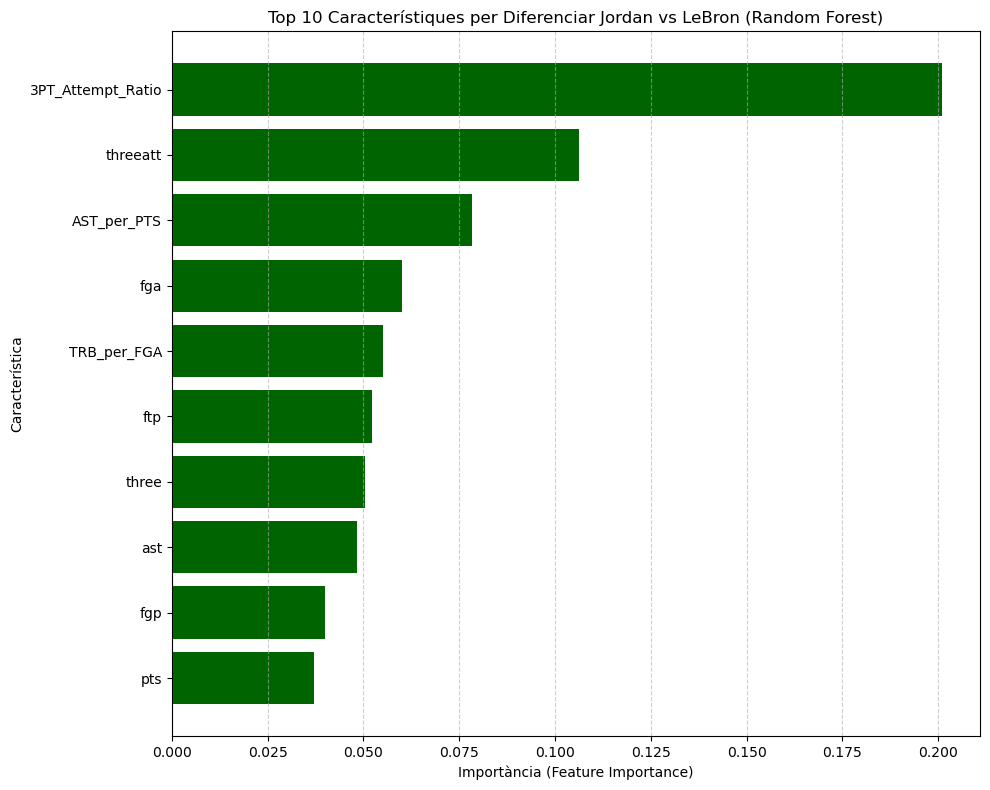


--- TOP 10 Característiques més Importants ---
Característica                 |  Importància
---------------------------------------------
3PT_Attempt_Ratio              |       0.2009
threeatt                       |       0.1064
AST_per_PTS                    |       0.0784
fga                            |       0.0600
TRB_per_FGA                    |       0.0550
ftp                            |       0.0522
three                          |       0.0503
ast                            |       0.0482
fgp                            |       0.0401
pts                            |       0.0372


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


# ======================================================
# 1. CARREGA I TRACTAMENT INICIAL DELS NaNs
# ======================================================

df = pd.read_csv("careers.csv", sep=";")

# Convertir mp ("MM:SS") -> minuts decimals
def mp_to_minutes(mp_str):
    try:
        m, s = mp_str.split(":")
        return int(m) + int(s)/60
    except:
        return np.nan

df["mp"] = df["mp"].apply(mp_to_minutes)

# Convertir totes les columnes (menys player) a numèriques
for col in df.columns:
    if col != "player":
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Omplir NaNs específics de percentatges
for col in ["threep", "ftp"]:
    df[col] = df[col].fillna(df[col].mean())


# ======================================================
# 2. FEATURE ENGINEERING (igual que al model de classificació)
# ======================================================

eps = 1e-6

df["AST_per_PTS"] = df["ast"] / (df["pts"] + eps)
df["3PT_Attempt_Ratio"] = df["threeatt"] / (df["fga"] + eps)
df["TRB_per_FGA"] = df["trb"] / (df["fga"] + eps)

df.replace([np.inf, -np.inf], np.nan, inplace=True)


# ======================================================
# 3. TRACTAMENT FINAL DE NaNs
# ======================================================

for col in df.columns:
    if col != "player":
        df[col] = df[col].fillna(df[col].mean())


# ======================================================
# 4. DEFINIR X I Y
# ======================================================

X = df.drop(columns=["player"])
Y = df["player"]


# ======================================================
# 5. ESCALAT DE DADES
# ======================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# ======================================================
# 6. ENTRENAMENT DEL RANDOM FOREST (per importància)
# ======================================================

rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_scaled, Y)


# ======================================================
# 7. IMPORTÀNCIA DE LES FEATURES
# ======================================================

feature_names = X.columns
importances = rf_model.feature_importances_

feature_importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

top_10 = feature_importances_df.head(10)


# ======================================================
# 8. GRÀFIC DE LES 10 FEATURES MÉS IMPORTANTS
# ======================================================

plt.figure(figsize=(10, 8))
plt.barh(top_10["Feature"], top_10["Importance"], color="darkgreen")
plt.xlabel("Importància (Feature Importance)")
plt.ylabel("Característica")
plt.title("Top 10 Característiques per Diferenciar Jordan vs LeBron (Random Forest)")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# ======================================================
# 9. TAULA AMB LES 10 MILLORS FEATURES
# ======================================================

print("\n--- TOP 10 Característiques més Importants ---")
print(f"{'Característica':<30} | {'Importància':>12}")
print("-" * 45)

for _, row in top_10.iterrows():
    print(f"{row['Feature']:<30} | {row['Importance']:>12.4f}")
